┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


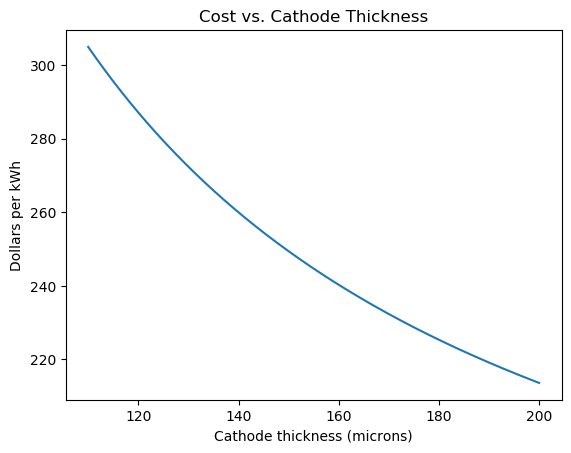

Figure(PyObject <Figure size 640x480 with 0 Axes>)

In [1]:
include("../src/PBCM.jl")

cell_general = cell()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()
cell_general, cost = convert_all(cell_general, cost, mult)

using PyPlot

    ###################################################### USD/kWh vs Thickness Cathode  ######################################################

param_x = []
param_y = []

cost.cell_costs.cathode.AM[1]   = 17.0
cell_general.cathode.por        = 0.4

for i in range(110, 200, length=1000)
    # cost.material.pos_AM[1] = i
    cell_general.cathode.th = converter(i, mult.pos_th)
    dollars_per_kWh, mfg_capacity = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)
    append!(param_y, dollars_per_kWh)
    append!(param_x, i)
end

# print(param_y)

clf()
plot(param_x, param_y)
xlabel(String("Cathode thickness (microns)"))
ylabel("Dollars per kWh")
title("Cost vs. Cathode Thickness")
figure(2)

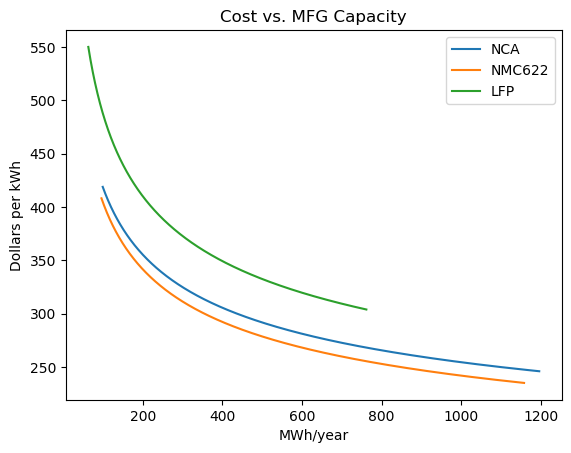

Figure(PyObject <Figure size 640x480 with 0 Axes>)

In [2]:
include("../src/PBCM.jl")

cell_general = cell()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()
cell_general, cost = convert_all(cell_general, cost, mult)




using PyPlot

    ###################################################### USD/kWh vs MWH/year  #####################################################################
cell_general.cathode.por = 0.3
cost.cell_costs.anode.AM[1] = 10.57
cost.cell_costs.cathode.AM[1] = 17.0
cell_general.cathode.th       = converter(150.0, mult.pos_th)
cell_general.design_verbosity = 0
cost_calc(cell_general, cost, system="Cell", cost_verbosity = 0)


clf()
data = ["NCA", "NMC622", "LFP"]
AM_rho_data = [4.71, 4.8, 3.6]
rev_sp_cap_data  = [0.180, 0.171, 0.150]
AM_price_data = [26.43, 17.83, 5.07]

for j in range(1, 3, step=1)
    cell_general.cathode.AM_rho = AM_rho_data[j]
    cell_general.cathode.rev_sp_cap = rev_sp_cap_data[j]
    cost.cell_costs.cathode.AM[1] =  AM_price_data[j]
    param_x = []
    param_y = []

    for i in range(10, 120, length=1000)
        # cost.material.pos_AM[1] = i
        cost.general_costs.no_units_mfg = converter(i, mult.units_mfg)
        dollars_per_kWh, mfg_capacity = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)
        append!(param_y, dollars_per_kWh)
        append!(param_x, mfg_capacity)
    end
    plot(param_x, param_y)
end


xlabel(String("MWh/year"))
ylabel("Dollars per kWh")
title("Cost vs. MFG Capacity")
legend(data)
figure(2)


The plot above shows the economies of scale for NCA, NMC622 and LFP with the cost data present in the script above. As we manufacture more cells, the unit material costs decrease as a result of more annual demand. This plot does not incorporate any sort of learning.



# Surface Plot

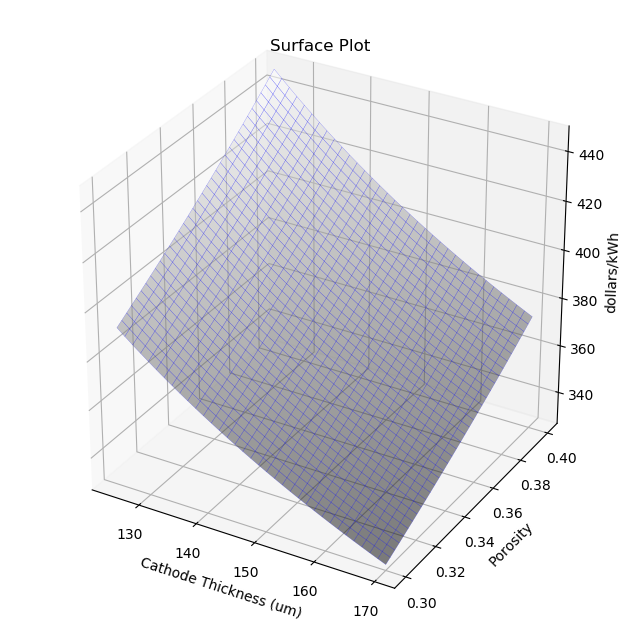

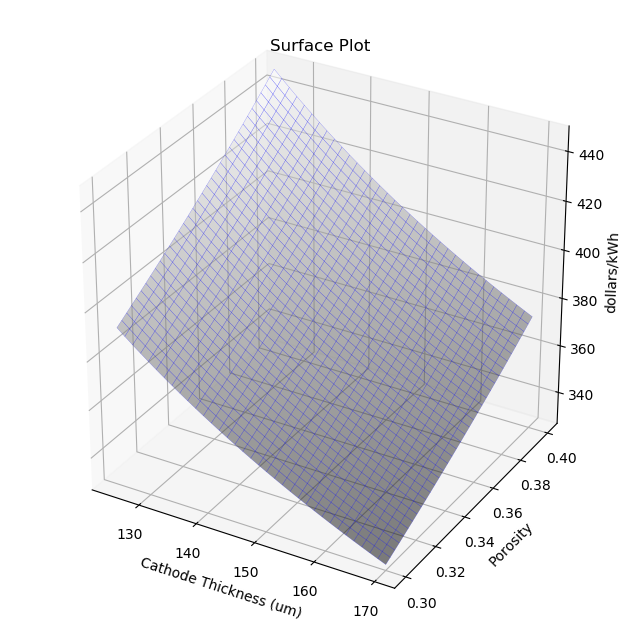

In [3]:
include("../src/PBCM.jl")

cell_general = cell()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()
cell_general, cost = convert_all(cell_general, cost, mult)


using PyPlot
using ForwardDiff

using3D()

cost.general_costs.no_units_mfg = converter(20.0, mult.units_mfg)
cost.cell_costs.cathode.AM[1]
n = 35

thic = range(125, stop=170, length=n)
poro = range(0.3, stop=0.4, length=n)

normalized_thic = range(0, 1, length = n)
normalized_poro = range(0, 1, length = n)


xgrid = repeat(thic', n, 1)
ygrid = repeat(poro, 1, n)

z = zeros(n,n)

z_grad_x = zeros(n,n)
z_grad_y = zeros(n,n)

legend_data = []


for i in 1:n, j in 1:n

    cell_general.cathode.por  = poro[j]
    cell_general.cathode.th   = converter(thic[i], mult.pos_th)


    dollars_kWh, MWh_per_year = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)
    z[j, i]                   = dollars_kWh

end


clf()
fig = figure("pyplot_surfaceplot", figsize=(8,8))
plot_surface(xgrid, ygrid, z, rstride=1, edgecolors="b", cstride=1, cmap=ColorMap("gray"), alpha=0.5, linewidth=0.1)
xlabel("Cathode Thickness (um)")
ylabel("Porosity")
zlabel("dollars/kWh")
title("Surface Plot")
figure(2)


#### The plot above shows the variation of cost wrt cathode thickness and porosity. 
Cost decreases as we increase the cathode thickness. For a given cell size, as we increase the cathode thickness, length of the jellyroll decreases. As a result of that, the amount of separators and current collectors needed decrease as well. Looking at the manufacturing costs, process costs for electrode coating decrease.

Cost increases as porosity increases. As we increase the porosity, energy per cell declines and consequently, the cost per kWh increases. Adding to that, unit materials cost increase as we need lesser materials annually.

# 1st Order GSA

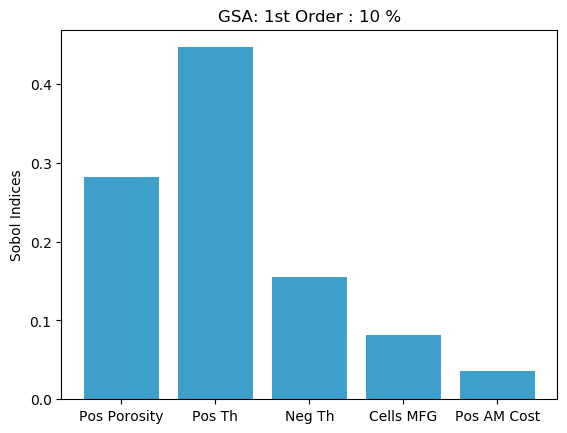

[0.2819593544809473, 0.4462680650081912, 0.15564280580965748, 0.08144501574096907, 0.03640269938314182]

Figure(PyObject <Figure size 640x480 with 0 Axes>)

In [4]:
include("../src/PBCM.jl")

cell_general = cell()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()
cell_general, cost = convert_all(cell_general, cost, mult)

using PyPlot
using DiffEqSensitivity

per = 10

poro = 0.35
poro_intrvl = [poro*(1 - (per/100)) , poro*(1 + (per/100))]

pos_thic = 150
pos_thic_intrvl = [pos_thic*(1 - (per/100)) , pos_thic*(1 + (per/100))]

neg_thic = 150
neg_thic_intrvl = [neg_thic*(1 - (per/100)) , neg_thic*(1 + (per/100))]

no_cells_yr = 10
no_cells_yr_intrvl = [no_cells_yr*(1 - (per/100)) , no_cells_yr*(1 + (per/100))]

cost_pos_AM = 25
cost_pos_AM_intrvl = [cost_pos_AM*(1 - (per/100)) , cost_pos_AM*(1 + (per/100))]


function gsa_cost(arr)

    cell_general.cathode.por        = arr[1]
    cell_general.cathode.th         = converter(arr[2], mult.pos_th)
    cell_general.anode.th           = converter(arr[3], mult.neg_th)
    cost.general_costs.no_units_mfg = converter(arr[4], mult.units_mfg)
    cost.cell_costs.cathode.AM[1]   = arr[5]

    dollars_kWh = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)[1]

    return dollars_kWh
end

# gsa_cost([0.25, 150.0, 130.0, 25.0, 19.0])

gsa_result = gsa(gsa_cost, Sobol(), [poro_intrvl, pos_thic_intrvl, neg_thic_intrvl, no_cells_yr_intrvl, cost_pos_AM_intrvl], N = 10000)


print("\n")
S1 = gsa_result.S1
print(S1)
clf()
x = ["Pos Porosity", "Pos Th", "Neg Th", "Cells MFG", "Pos AM Cost"]
bar(x, S1, color="#0f87bf", align="center", alpha=0.8)
ylabel("Sobol Indices")

title(string("GSA: 1st Order : ", per, " %"))
figure(2)


# 2nd Order GSA

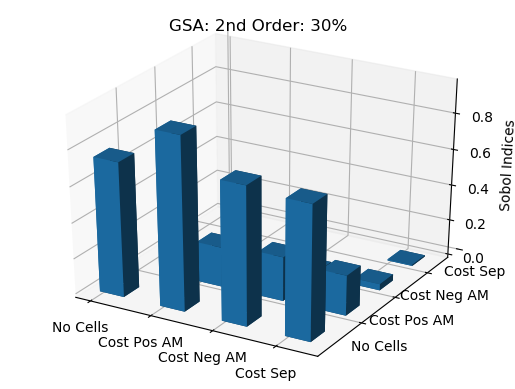


[0.7496516899114402, 0.22342109375819652, 0.026091982012750134, 0.006808488921112043][0.96457786127851, 0.7736753071199157, 0.7516172806305529, 0.24859442852981678, 0.2266074550560008, 0.035304579872657775]

Figure(PyObject <Figure size 640x480 with 0 Axes>)

In [5]:
include("../src/PBCM.jl")

cell_general = cell()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()
cell_general, cost = convert_all(cell_general, cost, mult)


using DiffEqSensitivity
using PyPlot

per = 30

no_cells_yr = 10
no_cells_yr_intrvl = [no_cells_yr*(1 - (per/100)) , no_cells_yr*(1 + (per/100))]

cost_pos_AM = 18.0
cost_pos_AM_intrvl = [cost_pos_AM*(1 - (per/100)) , cost_pos_AM*(1 + (per/100))]

cost_neg_AM = 12.5
cost_neg_AM_intrvl = [cost_neg_AM*(1 - (per/100)) , cost_neg_AM*(1 + (per/100))]

cost_sep = 1.1
cost_sep_intrvl    = [cost_sep  * (1 - (per/100)) , cost_sep * (1  + (per/100))]

function gsa_cost(arr)

    cost.general_costs.no_units_mfg   = converter(arr[1], mult.units_mfg)
    cost.cell_costs.cathode.AM[1]     = arr[2]
    cost.cell_costs.anode.AM[1]       = arr[3]
    cost.cell_costs.seperator_cost[1] = arr[4]

    dollars_kWh = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)[1]

    return dollars_kWh
end

# gsa_cost([0.25, 150.0, 130.0, 25.0, 19.0])

gsa_result = gsa(gsa_cost, Sobol(order = [2]), [no_cells_yr_intrvl, cost_pos_AM_intrvl, cost_neg_AM_intrvl, cost_sep_intrvl], N = 10000)


x = [0, 1, 2, 3, 1, 2, 3, 2, 3, 3]
y = [0, 0, 0, 0, 1, 1, 1, 2, 2, 3]

print("\n")
S1 = gsa_result.S1
S2 = gsa_result.S2
print(S1)
print(S2)

z = [S1[1],S2[1],S2[2],S2[3],S1[2],S2[4],S2[5],S1[3],S2[6],S1[4]]
clf()
r = bar3D(x, y, z*0, 0.4, 0.4, z)
xticks([0,1,2,3], ["No Cells","Cost Pos AM", "Cost Neg AM", "Cost Sep"])
yticks([1,2,3,4], ["No Cells","Cost Pos AM", "Cost Neg AM", "Cost Sep"])

title(string("GSA: 2nd Order: ", per, "%"))
zlabel("Sobol Indices")
figure(2)

# savefig("GSA.png", dpi=500)


The above two plots are the result of Global Sensitivity Analysis (GSA). Sobol method has been implemented to conduct GSA. It's a variance based sensitivity analysis. Greater the sobol index, greater it's contribution is towards the varince in cost. It's value is always between 0 and 1. Sobol indices can be defined as the ratio of partial variance to the total variance of cost.

First order GSA assesses cost by considering only one factor at a time. Second order GSA assesses the cost by considering one factor and it also considers the coupling effects or interaction effects between the various input parameters.